<a href="https://colab.research.google.com/github/KORshinjoonghyeok/Live-Tweets-Disaster-Analysis-with-BERT/blob/main/Live_Tweets_Disaster_Analysis_with_BERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install transformers

     |████████████████████████████████| 1.1MB 2.7MB/s 
     |████████████████████████████████| 1.1MB 16.5MB/s 
     |████████████████████████████████| 3.0MB 22.4MB/s 
     |████████████████████████████████| 890kB 45.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=01c3107b4d4bac1819b18fbe49f10626f145488794276bafa4e1351d82b62031
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tokenizers import BertWordPieceTokenizer
from tqdm.notebook import tqdm
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
import transformers
from transformers import TFAutoModel, AutoTokenizer
import matplotlib.pyplot as plt

In [4]:
try:
   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
   print('Running on TPU ', tpu.master())
except ValueError:
   tpu = None
 
if tpu:
   tf.config.experimental_connect_to_cluster(tpu)
   tf.tpu.experimental.initialize_tpu_system(tpu)
   strategy = tf.distribute.TPUStrategy(tpu)
else:
   strategy = tf.distribute.get_strategy()

In [5]:
!wget https://raw.githubusercontent.com/abcom-mltutorials/Live-Tweets-Disaster-Analysis-/master/train.csv?raw=true


--2020-10-11 13:52:20--  https://raw.githubusercontent.com/abcom-mltutorials/Live-Tweets-Disaster-Analysis-/master/train.csv?raw=true
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 987712 (965K) [text/plain]
Saving to: ‘train.csv?raw=true’

train.csv?raw=true  100%[===================>] 964.56K  --.-KB/s    in 0.1s    

2020-10-11 13:52:21 (6.31 MB/s) - ‘train.csv?raw=true’ saved [987712/987712]



In [6]:
train=pd.read_csv('/content/train.csv?raw=true')

In [7]:
train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [8]:
train.isnull().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

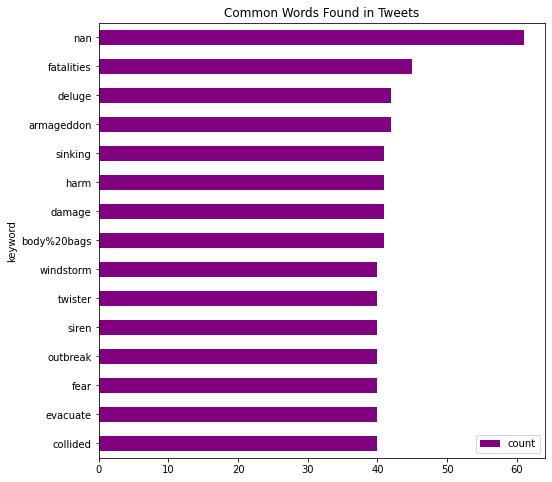

In [9]:
                            # empty list for holding keyword from each row of train['keyword']
keyword_combined=[]
for i in range(len(train)):
 keyword_combined.append(train['keyword'].iloc[i])

import collections
# count instances of each keyword
keyword_counters = collections.Counter(keyword_combined)
 
# make dataframe with words and their corresponding counts
keyword_with_counts = pd.DataFrame(keyword_counters.most_common(15),
                            columns=['keyword', 'count'])
 
fig, ax = plt.subplots(figsize=(8, 8))
 
# Plot horizontal bar graph
# plot the frequency distribution after sorting
keyword_with_counts.sort_values(by='count').plot.barh(x='keyword', 
                     y='count',
                     ax=ax,
                     color="purple")
 
ax.set_title("Common Words Found in Tweets")
 
plt.show()                                                                                                  

In [10]:
# dropping id, location, keyword column
train.drop(['id','location','keyword'],axis=1,inplace=True)

In [11]:
train['target'].value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [12]:
!pip install clean-text[gpl]
 
from cleantext import clean

     |████████████████████████████████| 71kB 2.7MB/s 
     |████████████████████████████████| 245kB 3.3MB/s 
  Created wheel for ftfy: filename=ftfy-5.8-cp36-none-any.whl size=45612 sha256=781769b9e6b8b00936d5458a37b6d18ee1d9d363b721b31b26c46817511ce68d
  Stored in directory: /root/.cache/pip/wheels/ba/c0/ef/f28c4da5ac84a4e06ac256ca9182fc34fa57fefffdbc68425b
Successfully built ftfy


In [13]:
def text_cleaning(text):
   text=clean(text,
     fix_unicode=True,               # fix various unicode errors
     to_ascii=True,                 # transliterate to closest ASCII representation
     lower=True,                    # lowercase text
     no_line_breaks=True,           # fully strip line breaks
     no_urls=True,                  # replace all URLs with ''
     no_emails=True,                # replace all email addresses with ''
     no_phone_numbers=True,         # replace all phone numbers with ''
     no_numbers=True,               # replace all numbers with ''
     no_digits=True,                # replace all digits with ''
     no_currency_symbols=True,      # replace all currency symbols with ''
     no_punct=True,                 # fully remove punctuation
     replace_with_url="",
     replace_with_email="",
     replace_with_phone_number="",
     replace_with_number="",
     replace_with_digit="",
     replace_with_currency_symbol="",
     lang="en"                      # set to 'en' for English
   )
   return text

In [14]:
for i in range(len(train)):
   train['text'].iloc[i]=text_cleaning(train['text'].iloc[i])

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [16]:
stoplist = stopwords.words('english')

In [17]:
for i in range(len(train)):
  train['text'].iloc[i] = [word for word in train['text'].iloc[i].split() if word not in stoplist]

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [18]:
print(train['text'])

0       [deeds, reason, earthquake, may, allah, forgiv...
1           [forest, fire, near, la, ronge, sask, canada]
2       [residents, asked, shelter, place, notified, o...
3       [people, receive, wildfires, evacuation, order...
4       [got, sent, photo, ruby, alaska, smoke, wildfi...
                              ...                        
7608    [two, giant, cranes, holding, bridge, collapse...
7609    [ariaahrary, thetawniest, control, wild, fires...
7610                             [utckm, volcano, hawaii]
7611    [police, investigating, ebike, collided, car, ...
7612    [latest, homes, razed, northern, california, w...
Name: text, Length: 7613, dtype: object
